## Libs

In [ ]:
import os
import ast
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sn
from tqdm.std import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import logging
logging.basicConfig(level='INFO')


logging.info(msg=f"Using tensorflow version : {tf.__version__}")

In [ ]:
import warnings
warnings.filterwarnings(action="ignore")

## Config & Helpers funcs

In [4]:
class Config:
    data_dir = '../data/'
    working_dir = '../src/'
    models_dir = '../models/'
    submissions_dir = '../submissions'


def preprocess_data(df:pd.DataFrame, skip_cols:list=None)->pd.DataFrame:
    """
        Parameters
        ----------
            df : Pandas dataframe
                Dataframe to be preprocessed.
                
            skip_cols : list
                list of columns to skip during preprocessing
                
        Returns
        -------
            df : Pandas dataframe
                Preprocessed dataframe.
        
        Examples
        --------
        >>> dataset = pd.read_csv(filepath_or_buffer='<path_to_data.csv>') 
        >>> new_df = preprocess_data(df=dataset) 
        
    """
    
    df = df.copy(deep=True)
    cols = [col for col in df.columns[1:] if col not in skip_cols]
    cat_cols = [col for col in cols if df[col].dtype == 'O' and 'Date' not in col]
    date_cols = [col for col in cols if 'Date' in col]
    
    # convert cat col to category type
    # print("Categorical cols", cat_cols)
    for col in tqdm(cat_cols, desc='Processing categorical columns \t'):
        df[col] = df[col].astype('category')
        
    # print("Date cols", date_cols)
    # convert date col to datetime type
    for col in tqdm(date_cols, desc='Processing datetime columns \t'):
        df[col] = pd.to_datetime(df[col]).dt.tz_localize(None)
    
    # fill missing values
    df.UpsellDate.fillna(value='None', inplace=True)
    df.Region.fillna(value=df.Region.mode()[0], inplace=True)
    df.Age.fillna(value=round(df.Age.mean()), inplace=True)
    
    for col in cat_cols:            
        try:
            df[col] = df[col].cat.codes
        except Exception as ex:
            logging.error(msg=f"Column issue ({col}) : {ex}")

        
    return df


def extract_features(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    df['RegisteredInLeapYear'] = df.RegistrationDate.dt.is_leap_year.astype('float')
    df['RegisteredAtMonthStart'] = df.RegistrationDate.dt.is_month_start.astype('float')
    df['RegisteredAtMonthEnd'] = df.RegistrationDate.dt.is_month_end.astype('float')
  #  df['LastPaymentMonth'] = df.LastPaymentDate.dt.month
    df['FirstPaymentMonth'] = df.FirstPaymentDate.dt.month
    df['FirstPaymentYear'] = df.FirstPaymentDate.dt.year
    
    lastReceivedPayment = []
    accessory_rate = []
    upsell_date = []
    for r in df.copy().iterrows():
        r = r[1]
        lastReceivedPayment.append(ast.literal_eval(r.TransactionDates)[-1])
        if r.AccessoryRate :
          r.AccessoryRate = 1
        accessory_rate.append(r.AccessoryRate)
        if r.UpsellDate != None :
          upsell_date.append(1)
        else :
          upsell_date.append(0)

    print(lastReceivedPayment)
    df['LastReceivedPayment'] = lastReceivedPayment
    df['LastReceivedPayment'] = pd.to_datetime(df['LastReceivedPayment']).dt.tz_localize(None)
    df['LastReceivedMonth'] = df.LastReceivedPayment.dt.month
    df['LastReceivedYear'] = df.LastReceivedPayment.dt.year
    df['LeftTime'] = (df['ExpectedTermDate'].dt.year-df['LastReceivedPayment'].dt.year)*12 + df['ExpectedTermDate'].dt.month -df['LastReceivedPayment'].dt.month 
    df['AccessoryRate'] = accessory_rate
    df['UpsellDate'] = upsell_date

    return df.drop(columns=["TransactionDates", "PaymentsHistory", "m1", "m2", "m3", "m4", "m5", "m6"], inplace=False)


def pad_history(df:pd.DataFrame, max_len:int=41):
    
    df = df.copy()
    
    padded_payments = []
    
    for r in df.copy().iterrows():
        r = r[1]
        
        if len(ast.literal_eval(r.PaymentsHistory)) > max_len:
            padded_payments.append(ast.literal_eval(r.PaymentsHistory)[:max_len])
            
        else:
            padding_len = abs(max_len - len(ast.literal_eval(r.PaymentsHistory)))
            padded_payments.append(ast.literal_eval(r.PaymentsHistory) + padding_len*[0.])
            
    
    df["PaymentsHistory"] = padded_payments
    
    del padded_payments
    
    return df, max_len

def pad_history_most_recent(df:pd.DataFrame, max_len:int=6):
    
    df = df.copy()
    
    padded_payments_1 = []
    padded_payments_2 = []
    padded_payments_3 = []
    padded_payments_4 = []
    padded_payments_5 = []
    padded_payments_6 = []
    remaining_payment = []
    RemainingPaymentPerUnitTimeLeft = []
    
    for r in df.copy().iterrows():
        r = r[1]
        padded_payments_1.append(ast.literal_eval(r.PaymentsHistory)[-1])
        padded_payments_2.append(ast.literal_eval(r.PaymentsHistory)[-2])
        padded_payments_3.append(ast.literal_eval(r.PaymentsHistory)[-3])
        padded_payments_4.append(ast.literal_eval(r.PaymentsHistory)[-4])
        padded_payments_5.append(ast.literal_eval(r.PaymentsHistory)[-5])
        remaining_payment.append(r.TotalContractValue - np.sum(ast.literal_eval(r.PaymentsHistory)[:]))
   #     RemainingPaymentPerUnitTimeLeft.append((r.TotalContractValue - np.sum(ast.literal_eval(r.PaymentsHistory)[:]))/r.LeftTime)
    
    df["PaymentsHistory_1"] = padded_payments_1
    df["PaymentsHistory_2"] = padded_payments_2
    df["PaymentsHistory_3"] = padded_payments_3
    df["PaymentsHistory_4"] = padded_payments_4
    df["PaymentsHistory_5"] = padded_payments_5
    df["RemainingPayment"] = remaining_payment

    
    del padded_payments_1
    
    return df

# Dataset
---
1. Load files
2. Exploratory Data Analysis (EDA)
3. Preprocess data
4. Extract features
4. Train/Test split

In [2]:
train = pd.read_csv( "Train.csv")
metadata = pd.read_csv( "metadata.csv")
test = pd.read_csv("Test.csv")
ss = pd.read_csv( "SampleSubmission.csv")

C:\Users\Rishabh Singhal\.conda\envs\cropChallenge\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28007 entries, 0 to 28006
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                28007 non-null  object 
 1   TransactionDates  28007 non-null  object 
 2   PaymentsHistory   28007 non-null  object 
 3   m1                28007 non-null  float64
 4   m2                28007 non-null  float64
 5   m3                28007 non-null  float64
 6   m4                28007 non-null  float64
 7   m5                28007 non-null  float64
 8   m6                28007 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.9+ MB


In [ ]:
train.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
m1,28007.0,815.411683,686.130805,1.0,275.0,820.0,1200.0,33890.0
m2,28007.0,807.101617,839.772177,1.0,250.0,800.0,1200.0,94044.0
m3,28007.0,797.641161,696.809281,1.0,220.0,790.0,1200.0,32005.0
m4,28007.0,815.011033,715.582046,1.0,230.0,815.0,1200.0,33403.0
m5,28007.0,827.719463,796.379837,1.0,220.0,840.0,1205.0,64106.0
m6,28007.0,692.115150,1416.301221,1.0,130.0,480.0,915.0,96814.0


In [ ]:
train.head(n=2)

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37343 entries, 0 to 37342
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   37343 non-null  object 
 1   RegistrationDate     37343 non-null  object 
 2   Deposit              37343 non-null  int64  
 3   UpsellDate           973 non-null    object 
 4   AccessoryRate        37343 non-null  float64
 5   PaymentMethod        37343 non-null  object 
 6   rateTypeEntity       37343 non-null  object 
 7   RatePerUnit          37343 non-null  int64  
 8   DaysOnDeposit        37343 non-null  int64  
 9   MainApplicantGender  37343 non-null  object 
 10  Age                  30404 non-null  float64
 11  Region               35409 non-null  object 
 12  Town                 37343 non-null  object 
 13  Occupation           37343 non-null  object 
 14  SupplierName         37343 non-null  object 
 15  Term                 37343 non-null 

In [ ]:
metadata.drop(columns=["SupplierName", "LastPaymentDate", "PaymentMethod", "rateTypeEntity"], inplace=True)

In [ ]:
metadata.describe(datetime_is_numeric=True).transpose()

,count,mean,std,min,25%,50%,75%,max
Deposit,37343.0,2348.631685,417.814614,0.0,2000.0,2000.0,2500.0,8000.0
AccessoryRate,37343.0,1.136090,7.791789,0.0,0.0,0.0,0.0,240.0
RatePerUnit,37343.0,49.923868,57.500215,35.0,40.0,40.0,55.0,4000.0
DaysOnDeposit,37343.0,4.600835,3.429060,0.0,3.0,3.0,7.0,60.0
Age,30404.0,38.855677,12.300827,19.0,29.0,36.0,46.0,120.0
Term,37343.0,412.427657,121.602544,10.0,364.0,364.0,547.0,626.0
TotalContractValue,37343.0,22953.005142,10149.863172,10800.0,16560.0,16560.0,33080.0,64484.0


In [ ]:
metadata.head(n=2)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate
0,ID_K00S4N4,2015-12-10 00:00:00,2000,NaN,0.0,35,7,Male,41.0,Mount Kenya Region,Embu,Other,364,14740.0,2016-12-08 00:00:00,2015-12-10 09:52:35
1,ID_6L67PAA,2015-12-09 00:00:00,2000,NaN,0.0,35,7,Male,33.0,Coast Region,Kilifi,Other,364,14740.0,2016-12-07 00:00:00,2015-12-09 13:14:03


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9336 entries, 0 to 9335
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                9336 non-null   object
 1   TransactionDates  9336 non-null   object
 2   PaymentsHistory   9336 non-null   object
dtypes: object(3)
memory usage: 218.9+ KB


In [ ]:
test.describe(datetime_is_numeric=True).transpose()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,count,unique,top,freq
ID,9336,9336,ID_NBKDYHW,1
TransactionDates,9336,2938,"['01-2020', '02-2020', '03-2020', '04-2020', '...",333
PaymentsHistory,9336,9290,"[3500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000....",15


In [ ]:
test.head(n=2)

,ID,TransactionDates,PaymentsHistory
0,ID_6L67PAA,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[4000.0, 1050.0, 1050.0, 1050.0, 1050.0, 400.0]"
1,ID_VJ80SX2,"['12-2015', '01-2016', '02-2016', '03-2016', '...","[3000.0, 850.0, 750.0, 1500.0, 650.0, 1250.0, ..."


In [ ]:
print("---------------- Missing values Report ----------------")
print(metadata.isna().sum())

---------------- Missing values Report ----------------
ID                         0
RegistrationDate           0
Deposit                    0
UpsellDate             36370
AccessoryRate              0
RatePerUnit                0
DaysOnDeposit              0
MainApplicantGender        0
Age                     6939
Region                  1934
Town                       0
Occupation                 0
Term                       0
TotalContractValue         0
ExpectedTermDate           0
FirstPaymentDate           0
dtype: int64


In [ ]:
merged = pd.merge(left=metadata, right=pd.concat(objs=[train, test]).fillna(value=0.), on="ID")

### Preprocessing

In [ ]:
merged_ = preprocess_data(df=merged, skip_cols=["PaymentsHistory", "TransactionDates"])

Processing datetime columns 	: 100%|██████████| 4/4 [00:00<00:00, 123.18it/s]


<function matplotlib.pyplot.show>

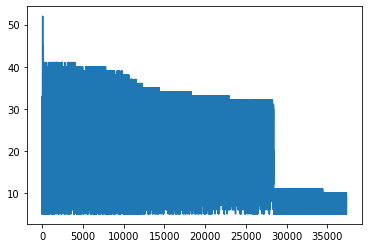

In [ ]:
c= []
for i in range (0,len(merged_)):
    c.append(len(ast.literal_eval(merged_.TransactionDates[i])))
import matplotlib.pyplot as plt
plt.plot(c)
plt.show

['04-2016', '07-2016', '08-2016', '10-2016', '11-2016', '06-2016', '06-2016', '07-2016', '02-2017', '11-2016', '06-2016', '06-2016', '08-2016', '02-2019', '07-2016', '10-2016', '06-2016', '02-2019', '06-2016', '09-2016', '07-2016', '07-2016', '10-2016', '09-2016', '03-2018', '06-2016', '09-2016', '07-2016', '09-2016', '05-2017', '06-2016', '07-2016', '09-2016', '05-2016', '05-2016', '05-2016', '06-2016', '06-2018', '08-2016', '08-2016', '01-2017', '09-2016', '08-2016', '07-2016', '07-2016', '06-2016', '03-2017', '06-2016', '10-2016', '05-2016', '06-2016', '05-2017', '06-2016', '06-2016', '11-2017', '06-2016', '09-2016', '06-2016', '08-2016', '05-2016', '05-2016', '07-2016', '11-2017', '06-2016', '11-2016', '06-2016', '06-2016', '08-2016', '07-2016', '11-2018', '04-2018', '05-2016', '05-2016', '01-2018', '08-2016', '07-2016', '11-2020', '06-2016', '09-2016', '05-2016', '08-2018', '07-2016', '03-2017', '07-2018', '08-2019', '05-2016', '06-2016', '11-2019', '01-2018', '07-2019', '01-2018'

<function matplotlib.pyplot.show>

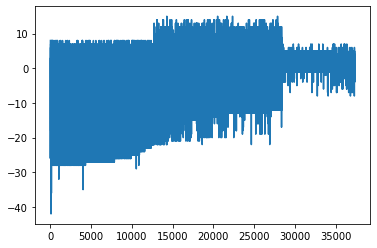

In [ ]:
merged_ = extract_features(df=merged_)
merged_.head(n=2)
plt.plot(merged_.LeftTime)
plt.show

In [ ]:
t = 0 
for i in range (0,len(merged_)):
  if merged_.LeftTime[i] > 5:
    t= t+1
print(len(merged_) - t, len(merged_))

34068 37343


In [ ]:
merged_.isna().sum()

ID                        0
RegistrationDate          0
Deposit                   0
UpsellDate                0
AccessoryRate             0
RatePerUnit               0
DaysOnDeposit             0
MainApplicantGender       0
Age                       0
Region                    0
Town                      0
Occupation                0
Term                      0
TotalContractValue        0
ExpectedTermDate          0
FirstPaymentDate          0
RegisteredInLeapYear      0
RegisteredAtMonthStart    0
RegisteredAtMonthEnd      0
FirstPaymentMonth         0
FirstPaymentYear          0
LastReceivedPayment       0
LastReceivedMonth         0
LastReceivedYear          0
LeftTime                  0
dtype: int64

### Features extraction

In [ ]:
#merged_ = extract_features(df=merged_)
merged_.head(n=20)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedPayment,LastReceivedMonth,LastReceivedYear,LeftTime
0,ID_K00S4N4,2015-12-10,2000,1,0.0,35,7,1,41.0,1,5,5,364,14740.0,2016-12-08,2015-12-10 09:52:35,0.0,0.0,0.0,12,2015,2016-04-01,4,2016,8
1,ID_6L67PAA,2015-12-09,2000,1,0.0,35,7,1,33.0,0,13,5,364,14740.0,2016-12-07,2015-12-09 13:14:03,0.0,0.0,0.0,12,2015,2016-07-01,7,2016,5
2,ID_102CV85,2015-12-18,2000,1,1.0,35,7,0,48.0,2,22,0,392,29480.0,2017-01-13,2015-12-18 06:22:34,0.0,0.0,0.0,12,2015,2016-08-01,8,2016,5
3,ID_HXBJFHB,2015-11-25,2000,1,0.0,35,7,0,43.0,4,43,6,364,14740.0,2016-11-23,2015-11-25 13:25:57,0.0,0.0,0.0,11,2015,2016-10-01,10,2016,1
4,ID_3K9VZ5J,2015-12-02,2000,1,0.0,35,7,0,56.0,1,14,5,364,14740.0,2016-11-30,2015-12-05 10:34:32,0.0,0.0,0.0,12,2015,2016-11-01,11,2016,0
5,ID_VJ80SX2,2015-12-14,2000,1,0.0,35,7,0,39.0,1,5,0,364,14740.0,2016-12-12,2015-12-14 14:20:26,0.0,0.0,0.0,12,2015,2016-06-01,6,2016,6
6,ID_6YU5YRB,2015-12-10,2000,1,0.0,35,7,1,56.0,1,25,5,364,14740.0,2016-12-08,2015-12-10 15:15:16,0.0,0.0,0.0,12,2015,2016-06-01,6,2016,6
7,ID_FK5A5E9,2015-12-11,2000,1,0.0,35,7,0,41.0,1,5,5,364,14740.0,2016-12-09,2015-12-11 10:34:10,0.0,0.0,0.0,12,2015,2016-07-01,7,2016,5
8,ID_7OU9HLK,2015-12-06,2000,1,0.0,35,7,1,32.0,1,5,0,364,14740.0,2016-12-04,2015-12-06 16:41:21,0.0,0.0,0.0,12,2015,2017-02-01,2,2017,-2
9,ID_WVWTPGK,2015-12-05,2000,1,0.0,35,7,0,42.0,1,14,5,364,14740.0,2016-12-03,2015-12-04 18:11:33,0.0,0.0,0.0,12,2015,2016-11-01,11,2016,1


In [ ]:
merged_['LeftTime'].unique()

array([  8,   5,   1,   0,   6,  -2,   4, -26,   2,   3, -16,  -5,   7,
       -18,  -1,  -3, -12, -11,  -4, -42, -20, -13, -29,  -9, -37,  -7,
       -35,  -6, -21, -28, -36, -24, -19, -15, -14, -25, -27,  -8, -23,
       -22, -10, -17, -32,  13,  10,   9,  12,  14,  11,  15])

In [ ]:
merged_.head(2)

,ID,RegistrationDate,Deposit,UpsellDate,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedPayment,LastReceivedMonth,LastReceivedYear,LeftTime
0,ID_K00S4N4,2015-12-10,2000,1,0.0,35,7,1,41.0,1,5,5,364,14740.0,2016-12-08,2015-12-10 09:52:35,0.0,0.0,0.0,12,2015,2016-04-01,4,2016,8
1,ID_6L67PAA,2015-12-09,2000,1,0.0,35,7,1,33.0,0,13,5,364,14740.0,2016-12-07,2015-12-09 13:14:03,0.0,0.0,0.0,12,2015,2016-07-01,7,2016,5


In [ ]:
# RegistrationDate , UpsellDate , Region , Town , Occupation , ExpectedTermDate , FirstPaymentDate , LastReceivedPayment

In [ ]:
for i in merged_.columns:
    print(type(merged_[i][1]),i)

<class 'str'> ID
<class 'pandas._libs.tslibs.timestamps.Timestamp'> RegistrationDate
<class 'numpy.longlong'> Deposit
<class 'numpy.longlong'> UpsellDate
<class 'numpy.float64'> AccessoryRate
<class 'numpy.longlong'> RatePerUnit
<class 'numpy.longlong'> DaysOnDeposit
<class 'numpy.int8'> MainApplicantGender
<class 'numpy.float64'> Age
<class 'numpy.int8'> Region
<class 'numpy.int8'> Town
<class 'numpy.int8'> Occupation
<class 'numpy.longlong'> Term
<class 'numpy.float64'> TotalContractValue
<class 'pandas._libs.tslibs.timestamps.Timestamp'> ExpectedTermDate
<class 'pandas._libs.tslibs.timestamps.Timestamp'> FirstPaymentDate
<class 'numpy.float64'> RegisteredInLeapYear
<class 'numpy.float64'> RegisteredAtMonthStart
<class 'numpy.float64'> RegisteredAtMonthEnd
<class 'numpy.longlong'> FirstPaymentMonth
<class 'numpy.longlong'> FirstPaymentYear
<class 'pandas._libs.tslibs.timestamps.Timestamp'> LastReceivedPayment
<class 'numpy.longlong'> LastReceivedMonth
<class 'numpy.longlong'> LastRec

In [ ]:
selected_features = [c for c in merged_.columns[1:] if "Date" not in c]
selected_features

['Deposit',
 'AccessoryRate',
 'RatePerUnit',
 'DaysOnDeposit',
 'MainApplicantGender',
 'Age',
 'Region',
 'Town',
 'Occupation',
 'Term',
 'TotalContractValue',
 'RegisteredInLeapYear',
 'RegisteredAtMonthStart',
 'RegisteredAtMonthEnd',
 'FirstPaymentMonth',
 'FirstPaymentYear',
 'LastReceivedPayment',
 'LastReceivedMonth',
 'LastReceivedYear',
 'LeftTime']

In [ ]:
selected_features = [c for c in merged_.columns[1:] if "Date" not in c]
xtrain_loan = merged_[selected_features]
ytrain_loan = merged_.Target
## Split
xtrain_loan, xval_loan, ytrain_loan, yval_loan = train_test_split(
    xtrain_loan, 
    ytrain_loan, 
    test_size=.3, 
    random_state=21, 
    shuffle=True
)
scaler = StandardScaler()
##Fit scaler
scaler.fit(X=xtrain_loan.values)

## Scale data
xtrain_loan = scaler.transform(X=xtrain_loan.values)
xval_loan = scaler.transform(X=xval_loan.values)

print(f"> Training inputs shape : {xtrain_loan.shape}, Training targets shape : {ytrain_loan.shape}")
print(f"> Validation inputs shape : {xval_loan.shape}, Training targets shape : {yval_loan.shape}")

### Train/Val split

In [ ]:
#train = pad_history_most_recent(df=train, max_len=5)
train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0


In [ ]:
merged_train = pd.merge(left=train, right=pd.concat(objs=[merged_]).fillna(value=0.), on="ID")
merged_train = pad_history_most_recent(df=merged_train, max_len=5)
merged_train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,RegistrationDate,Deposit,UpsellDate,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Occupation,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedPayment,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,2018-04-23 12:28:05,2500,1,0.0,55,3,1,39.0,0,18,6,556,33080.0,2019-10-31 12:28:05,2018-04-23 12:28:05,0.0,0.0,0.0,4,2018,2020-11-01,11,2020,-13,770.0,280.0,1320.0,1200.0,660.0,17045.0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,2018-04-17 10:27:35,2500,1,0.0,55,3,1,26.0,5,32,2,556,33080.0,2019-10-25 10:27:35,2018-04-17 10:27:35,0.0,0.0,0.0,4,2018,2020-11-01,11,2020,-13,770.0,655.0,660.0,660.0,605.0,10944.0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2020-02-18 14:23:44,2400,1,0.0,50,3,1,21.0,1,5,0,240,14400.0,2020-10-15 14:23:44,2020-02-18 14:23:48,1.0,0.0,0.0,2,2020,2020-07-01,7,2020,3,250.0,200.0,610.0,1350.0,1500.0,7640.0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,2017-09-14 11:07:40,2000,1,0.0,40,7,0,26.0,1,25,2,364,16560.0,2018-09-13 11:07:40,2017-09-14 11:07:32,0.0,0.0,0.0,9,2017,2018-06-01,6,2018,3,380.0,600.0,1100.0,1300.0,780.0,5300.0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,2017-09-06 06:50:20,2000,1,0.0,40,7,1,27.0,3,47,2,364,16560.0,2018-09-05 06:50:20,2017-09-06 06:50:16,0.0,0.0,0.0,9,2017,2019-11-01,11,2019,-14,520.0,80.0,40.0,40.0,80.0,8781.0


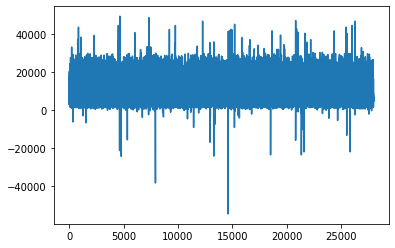

In [ ]:
plt.plot(merged_train.RemainingPayment)

In [ ]:
# func that returns a dummified DataFrame of significant dummies in a given column
def dum_sign(dummy_col, threshold=0.01):

    # removes the bind
    dummy_col = dummy_col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios is higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "others"

    return pd.get_dummies(dummy_col, prefix=dummy_col.name)

merged_train = pd.concat([merged_train, dum_sign(merged_train['DaysOnDeposit'])], axis=1)
merged_train = pd.concat([merged_train, dum_sign(merged_train['Occupation'])], axis=1)
merged_train = pd.concat([merged_train, dum_sign(merged_train['Region'])], axis=1)
merged_train.drop(columns=[ "DaysOnDeposit_others", "Occupation" ], inplace=True)
merged_train.head()

,ID,TransactionDates,PaymentsHistory,m1,m2,m3,m4,m5,m6,RegistrationDate,Deposit,UpsellDate,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Region,Town,Term,TotalContractValue,ExpectedTermDate,FirstPaymentDate,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedPayment,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment,DaysOnDeposit_3,DaysOnDeposit_7,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6
0,ID_MR53LEX,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[3600.0, 750.0, 350.0, 65.0, 95.0, 135.0, 85.0...",880.0,930.0,495.0,715.0,220.0,385.0,2018-04-23 12:28:05,2500,1,0.0,55,3,1,39.0,0,18,556,33080.0,2019-10-31 12:28:05,2018-04-23 12:28:05,0.0,0.0,0.0,4,2018,2020-11-01,11,2020,-13,770.0,280.0,1320.0,1200.0,660.0,17045.0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,ID_3D7NQUH,"['04-2018', '05-2018', '06-2018', '07-2018', '...","[2940.0, 970.0, 380.0, 880.0, 385.0, 440.0, 11...",660.0,935.0,935.0,825.0,770.0,935.0,2018-04-17 10:27:35,2500,1,0.0,55,3,1,26.0,5,32,556,33080.0,2019-10-25 10:27:35,2018-04-17 10:27:35,0.0,0.0,0.0,4,2018,2020-11-01,11,2020,-13,770.0,655.0,660.0,660.0,605.0,10944.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,ID_0IWQNPI,"['02-2020', '03-2020', '04-2020', '05-2020', '...","[2850.0, 1500.0, 1350.0, 610.0, 200.0, 250.0]",700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2020-02-18 14:23:44,2400,1,0.0,50,3,1,21.0,1,5,240,14400.0,2020-10-15 14:23:44,2020-02-18 14:23:48,1.0,0.0,0.0,2,2020,2020-07-01,7,2020,3,250.0,200.0,610.0,1350.0,1500.0,7640.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,ID_IY8SYB9,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2200.0, 1420.0, 1180.0, 900.0, 1400.0, 780.0,...",580.0,480.0,800.0,1260.0,1650.0,530.0,2017-09-14 11:07:40,2000,1,0.0,40,7,0,26.0,1,25,364,16560.0,2018-09-13 11:07:40,2017-09-14 11:07:32,0.0,0.0,0.0,9,2017,2018-06-01,6,2018,3,380.0,600.0,1100.0,1300.0,780.0,5300.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,ID_9XHL7VZ,"['09-2017', '10-2017', '11-2017', '12-2017', '...","[2640.0, 910.0, 480.0, 280.0, 200.0, 180.0, 33...",40.0,440.0,460.0,360.0,80.0,330.0,2017-09-06 06:50:20,2000,1,0.0,40,7,1,27.0,3,47,364,16560.0,2018-09-05 06:50:20,2017-09-06 06:50:16,0.0,0.0,0.0,9,2017,2019-11-01,11,2019,-14,520.0,80.0,40.0,40.0,80.0,8781.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
merged_train.drop(columns=["RegistrationDate" , "UpsellDate" , "Region" , "Town"  , "ExpectedTermDate" , "FirstPaymentDate" , "LastReceivedPayment", "TransactionDates", "PaymentsHistory"], inplace=True)
merged_train.head()

,ID,m1,m2,m3,m4,m5,m6,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment,DaysOnDeposit_3,DaysOnDeposit_7,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6
0,ID_MR53LEX,880.0,930.0,495.0,715.0,220.0,385.0,2500,0.0,55,3,1,39.0,556,33080.0,0.0,0.0,0.0,4,2018,11,2020,-13,770.0,280.0,1320.0,1200.0,660.0,17045.0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,ID_3D7NQUH,660.0,935.0,935.0,825.0,770.0,935.0,2500,0.0,55,3,1,26.0,556,33080.0,0.0,0.0,0.0,4,2018,11,2020,-13,770.0,655.0,660.0,660.0,605.0,10944.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,ID_0IWQNPI,700.0,1350.0,1550.0,1400.0,1450.0,1200.0,2400,0.0,50,3,1,21.0,240,14400.0,1.0,0.0,0.0,2,2020,7,2020,3,250.0,200.0,610.0,1350.0,1500.0,7640.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,ID_IY8SYB9,580.0,480.0,800.0,1260.0,1650.0,530.0,2000,0.0,40,7,0,26.0,364,16560.0,0.0,0.0,0.0,9,2017,6,2018,3,380.0,600.0,1100.0,1300.0,780.0,5300.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,ID_9XHL7VZ,40.0,440.0,460.0,360.0,80.0,330.0,2000,0.0,40,7,1,27.0,364,16560.0,0.0,0.0,0.0,9,2017,11,2019,-14,520.0,80.0,40.0,40.0,80.0,8781.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
y_true_1 = merged_train.m1.values
y_true_2 = merged_train.m2.values
y_true_3 = merged_train.m3.values
y_true_4 = merged_train.m4.values
y_true_5 = merged_train.m5.values
y_true_6 = merged_train.m6.values
merged_train.drop(columns=["m1", "m2" ,"m3", "m4", "m5", "m6"], inplace=True)
merged_train.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,RegisteredInLeapYear,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment,DaysOnDeposit_3,DaysOnDeposit_7,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6
0,ID_MR53LEX,2500,0.0,55,3,1,39.0,556,33080.0,0.0,0.0,0.0,4,2018,11,2020,-13,770.0,280.0,1320.0,1200.0,660.0,17045.0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,ID_3D7NQUH,2500,0.0,55,3,1,26.0,556,33080.0,0.0,0.0,0.0,4,2018,11,2020,-13,770.0,655.0,660.0,660.0,605.0,10944.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,ID_0IWQNPI,2400,0.0,50,3,1,21.0,240,14400.0,1.0,0.0,0.0,2,2020,7,2020,3,250.0,200.0,610.0,1350.0,1500.0,7640.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,ID_IY8SYB9,2000,0.0,40,7,0,26.0,364,16560.0,0.0,0.0,0.0,9,2017,6,2018,3,380.0,600.0,1100.0,1300.0,780.0,5300.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,ID_9XHL7VZ,2000,0.0,40,7,1,27.0,364,16560.0,0.0,0.0,0.0,9,2017,11,2019,-14,520.0,80.0,40.0,40.0,80.0,8781.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
merged_train.drop(columns=["RegisteredInLeapYear" ], inplace=True)
merged_train.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment,DaysOnDeposit_3,DaysOnDeposit_7,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6
0,ID_MR53LEX,2500,0.0,55,3,1,39.0,556,33080.0,0.0,0.0,4,2018,11,2020,-13,770.0,280.0,1320.0,1200.0,660.0,17045.0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,ID_3D7NQUH,2500,0.0,55,3,1,26.0,556,33080.0,0.0,0.0,4,2018,11,2020,-13,770.0,655.0,660.0,660.0,605.0,10944.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,ID_0IWQNPI,2400,0.0,50,3,1,21.0,240,14400.0,0.0,0.0,2,2020,7,2020,3,250.0,200.0,610.0,1350.0,1500.0,7640.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,ID_IY8SYB9,2000,0.0,40,7,0,26.0,364,16560.0,0.0,0.0,9,2017,6,2018,3,380.0,600.0,1100.0,1300.0,780.0,5300.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,ID_9XHL7VZ,2000,0.0,40,7,1,27.0,364,16560.0,0.0,0.0,9,2017,11,2019,-14,520.0,80.0,40.0,40.0,80.0,8781.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
merged_train.drop(columns=["RegisteredAtMonthStart", "RegisteredAtMonthEnd" ], inplace=True)
merged_train.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment,DaysOnDeposit_3,DaysOnDeposit_7,Occupation_0,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Region_0,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6
0,ID_MR53LEX,2500,0.0,55,3,1,39.0,556,33080.0,4,2018,11,2020,-13,770.0,280.0,1320.0,1200.0,660.0,17045.0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,ID_3D7NQUH,2500,0.0,55,3,1,26.0,556,33080.0,4,2018,11,2020,-13,770.0,655.0,660.0,660.0,605.0,10944.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,ID_0IWQNPI,2400,0.0,50,3,1,21.0,240,14400.0,2,2020,7,2020,3,250.0,200.0,610.0,1350.0,1500.0,7640.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,ID_IY8SYB9,2000,0.0,40,7,0,26.0,364,16560.0,9,2017,6,2018,3,380.0,600.0,1100.0,1300.0,780.0,5300.0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,ID_9XHL7VZ,2000,0.0,40,7,1,27.0,364,16560.0,9,2017,11,2019,-14,520.0,80.0,40.0,40.0,80.0,8781.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0


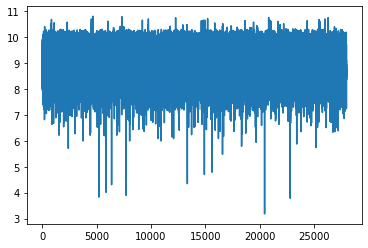

In [ ]:
merged_train['Age'] = np.log(merged_train['Age']+1)
merged_train['RemainingPayment'] = np.log(merged_train['RemainingPayment']+1)
plt.plot(merged_train['RemainingPayment'])

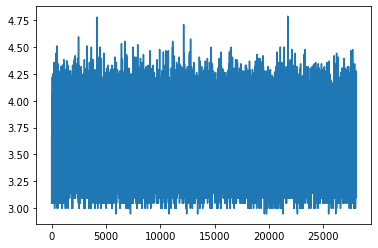

In [ ]:
plt.plot(merged_train['Age'])

In [ ]:
########################### Model params
#################################################################################
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.015,
                    'num_leaves': 2**8-1,
                    'min_data_in_leaf': 2**8-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1000,
                    'boost_from_average': False,
                    'verbose': 1,
                    'seed' : 1995, 
                    'random_state' : 21,
                    'is_unbalance': True,
                    'max_depth' : 7
                }

In [ ]:
# Hyperparameter grid
param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': list(range(20, 2**8-1)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}
MAX_EVALS = 5
N_FOLDS = 5
grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
com = 1
for x in param_grid.values():
    com *= len(x)
print('There are {} combinations'.format(com))

There are 3158400000000000 combinations


In [ ]:
import itertools

def grid_search(param_grid, max_evals = MAX_EVALS):
    """Grid search algorithm (with limit on max evals)"""
    
    # Dataframe to store results
    results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))
    
    # https://codereview.stackexchange.com/questions/171173/list-all-possible-permutations-from-a-python-dictionary-of-lists
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    # Iterate through every possible combination of hyperparameters
    for v in itertools.product(*values):
        
        # Create a hyperparameter dictionary
        hyperparameters = dict(zip(keys, v))
        
        # Set the subsample ratio accounting for boosting type
        hyperparameters['subsample'] = 1.0 if hyperparameters['boosting_type'] == 'goss' else hyperparameters['subsample']
        
        # Evalute the hyperparameters
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
        i += 1
        
        # Normally would not limit iterations
        if i > MAX_EVALS:
            break
       
    # Sort with best score on top
    results.sort_values('score', ascending = False, inplace = True)
    results.reset_index(inplace = True)
    
    return results  

def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, lgbtrain_all, num_boost_round = 100000, nfold = N_FOLDS, 
                        early_stopping_rounds = 500, metrics = 'auc', seed = 42)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

In [ ]:
grid_results = grid_search(param_grid)

print('The best validation score was {:.5f}'.format(grid_results.loc[0, 'score']))
print('\nThe best hyperparameters were:')

import pprint
pprint.pprint(grid_results.loc[0, 'params'])

The best validation score was 1.00000

The best hyperparameters were:
{'boosting_type': 'gbdt',
 'colsample_bytree': 0.6,
 'is_unbalance': True,
 'learning_rate': 0.004999999999999999,
 'min_child_samples': 20,
 'n_estimators': 1,
 'num_leaves': 20,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.5,
 'subsample_for_bin': 20000}


In [ ]:
import lightgbm as lgb
# LightGBM dataset
y_true_train_1 = y_true_6[:-1000]
merged_train_1_train = merged_train[:27007]
lgbtrain_all = lgb.Dataset(data=merged_train_1_train.loc[:len(merged_train_1_train),merged_train_1_train.columns[1:]].values, 
                           label=y_true_train_1)
model = lgb.train(lgb_params, train_set = lgbtrain_all)
test_preds = model.predict(merged_train.loc[27007:,merged_train.columns[1:]].values)
test_preds[:50]

array([ 286.13958596,  527.0134186 ,  677.73942243,  566.51994067,
        681.62295676,  706.23076343,  357.04586507,  544.48344914,
       1146.84312439,  324.00846469,  698.85727797,  751.10007977,
        703.59123034, 1064.71949246,  175.90394685, 1546.70449024,
        456.4130558 ,  293.31516836,  214.30613613,  277.50475141,
        316.70130976,  644.05842813,  698.32830949,  233.36612337,
        675.06510873,  394.20875463, 1311.96835534,  623.08345549,
        729.53100075,  493.96534188,  946.1415297 , 1049.91228163,
        526.03358822,  154.53677844,  442.44151218, 1153.8663424 ,
       1672.86804779,  156.81078463,  334.2875533 ,  758.2612044 ,
        155.02382295, 2340.58428294,  610.69409373, 4352.84216781,
        410.40740768,  283.84799645,  711.87243208,  650.04142217,
        238.41338669,  459.22036452])

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(l2_regularization=1, learning_rate=0.0015,
                              loss='least_squares', max_bins=255,
                              max_depth=7, max_iter=10000, max_leaf_nodes=2**8-1,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=5, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=1,
                              warm_start=False)

y_true_train_1 = y_true_1[:-1000]
merged_train_1_train = merged_train[:27007]
model.fit(merged_train_1_train.loc[:,merged_train.columns[1:]], y_true_train_1)
test_preds_hist = model.predict(merged_train.loc[27007:,merged_train.columns[1:]].values)
test_preds_hist[:50]

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=2000, max_depth=6, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.012, loss='huber',
                                           random_state=5, verbose = 1)
y_true_train_1 = y_true_1[:-1000]
merged_train_1_train = merged_train[:27007]
model.fit(merged_train_1_train.loc[:,merged_train.columns[1:]], y_true_train_1)
test_preds_gbr = model.predict(merged_train.loc[27007:,merged_train.columns[1:]].values)
test_preds_gbr[:50]

      Iter       Train Loss   Remaining Time 
         1      213725.1633            4.55m
         2      210317.9078            4.72m
         3      206610.0850            4.67m
         4      203174.2558            4.64m
         5      199989.6395            4.62m
         6      196814.9778            4.62m
         7      193801.9101            4.61m
         8      191077.7212            4.60m
         9      188524.3130            4.59m
        10      185939.9401            4.59m
        20      165897.4225            4.52m
        30      153607.1354            4.49m
        40      144635.0788            4.47m
        50      139022.7550            4.45m
        60      134947.1816            4.43m
        70      131624.7370            4.39m
        80      129170.8038            4.35m
        90      127212.2840            4.32m
       100      125659.4579            4.28m
       200      116665.6483            3.97m
       300      110324.8607            3.72m
       40

array([ 192.23857379,  565.88669195,  587.26310637,  588.01971807,
        677.4088525 ,  514.97405499,  348.10528794,  296.58766043,
        973.80762655,  405.69392287,  670.1764298 ,  763.40452873,
        511.74701329, 1100.92400453,  105.1117409 , 1782.00951312,
        366.08712755,   83.61390192,  159.28512254,  242.93225731,
        223.24361049,  731.69545925,  620.48918758,  119.79002432,
        536.64795478,  307.1435876 ,  440.19171664,  224.73319434,
        781.19838644,  351.82137752, 1030.18433494, 1278.72834276,
        419.03810911,  115.41881877,  390.9921848 ,  975.76436814,
       1843.5308732 ,  260.24157905,  298.49068865,  770.79935072,
         81.51907802, 1806.80020857,  569.9756016 , 2632.69441823,
        355.91008779,  626.76378986,  795.84340905,  611.79324464,
        257.78788888,  360.68998551])

In [ ]:
merged_train_1_val = merged_train[27007:]
merged_train_1_val = scaler.transform(merged_train_1_val.loc[:,merged_train.columns[1:]])
test_preds_gbr = model.predict(merged_train_1_val)
test_preds_gbr[:50]

array([ 163.07119281, 1700.04820059,  621.02789652,  605.89642791,
        734.59468732,  548.72856296,  346.14495924,  153.80809327,
        910.79449033,  362.93397709,  702.29951331,  750.66947107,
        490.94334151, 1184.02669621,  101.89958898, 1477.85074237,
        370.46651891,   70.26695556,  148.45317868,  231.10303464,
        198.20740505,  782.19662206,  662.86220242,  104.17224371,
        451.96271542,  260.67732657,  318.52454406,  342.05713816,
        797.21902956,  453.49924384,  683.74190796, 1288.95111714,
        462.96699249,  468.42448561,  339.31234618, 1003.88570794,
       2626.52716561,  276.73850973,  329.40345273,  843.02469298,
         88.98597166, 1717.97915217,  480.08686435, 4084.99262897,
        457.12262313,  620.22771272,  859.25800591,  674.55535121,
        224.68955104,  341.29575444])

In [ ]:
import xgboost as xgb
y_true_train_1 = y_true_3[:-1000]
merged_train_1_train = merged_train[:27007]
xgbtrain = xgb.DMatrix(merged_train_1_train.loc[:len(merged_train_1_train),merged_train_1_train.columns[1:]].values, y_true_train_1)
param = {'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.4,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1995,
         'silent':0,
         'eval_metric':'rmse'} # random parameters
model = xgb.train(param, xgbtrain)
model
xgbpredict = xgb.DMatrix(merged_train.loc[27007:,merged_train.columns[1:]].values)
test_preds_xgb = model.predict(xgbpredict)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true_1[27007:], test_preds_gbr, squared=False)

1067.8438456984177

In [ ]:
best = ['gb - 1068, lgb - 1063.4','lgb - 376 , gb -390', ' ', '', '', 'gb - 1396']

In [ ]:
for i in range(0,len(test_preds)):
    test_preds[i] = (test_preds_xgb[i] + test_preds[i])/2
mean_squared_error(y_true_3[27007:], test_preds, squared=False)

In [ ]:
for i in range(0,len(test_preds)):
    test_preds[i] = (test_preds_xgb[i] + test_preds[i])/2
mean_squared_error(y_true_6[27007:], test_preds, squared=False)

In [ ]:
for i in range (0,1000):
  if test_preds[i] >1200 :
    test_preds[i] = 1500

In [ ]:
plt.plot(test_preds)

In [ ]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=merged_train.loc[:,merged_train.columns].values, 
                           label=y_true_1, 
                           feature_name = merged_train.columns)
cols = merged_train.columns
merged_train.loc[:,cols].values

In [ ]:
merged_test = pd.merge(left=test, right=pd.concat(objs=[merged_]).fillna(value=0.), on="ID")
merged_test = pad_history_most_recent(df=merged_test, max_len=5)
merged_test.drop(columns=["RegistrationDate" , "UpsellDate" , "Region" , "Town" , "Occupation" , "ExpectedTermDate" , "FirstPaymentDate" , "LastReceivedPayment", "TransactionDates", "PaymentsHistory"], inplace=True)
merged_test.drop(columns=["RegisteredInLeapYear" ], inplace=True)
merged_test.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,RegisteredAtMonthStart,RegisteredAtMonthEnd,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment
0,ID_6L67PAA,2000,0.0,35,7,1,33.0,364,14740.0,0.0,0.0,12,2015,7,2016,5,400.0,1050.0,1050.0,1050.0,1050.0,6140.0
1,ID_VJ80SX2,2000,0.0,35,7,0,39.0,364,14740.0,0.0,0.0,12,2015,6,2016,6,1000.0,1250.0,650.0,1500.0,750.0,5740.0
2,ID_7OU9HLK,2000,0.0,35,7,1,32.0,364,14740.0,0.0,0.0,12,2015,2,2017,-2,175.0,875.0,700.0,675.0,450.0,8665.0
3,ID_WVWTPGK,2000,0.0,35,7,0,42.0,364,14740.0,0.0,0.0,12,2015,11,2016,1,485.0,800.0,925.0,1015.0,1010.0,-455.0
4,ID_04DSDQS,2000,0.0,35,7,0,38.0,364,14740.0,0.0,0.0,12,2015,8,2016,4,500.0,500.0,1000.0,750.0,1300.0,3150.0


In [ ]:
merged_test.drop(columns=["RegisteredAtMonthStart", "RegisteredAtMonthEnd" ], inplace=True)
merged_test.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment
0,ID_6L67PAA,2000,0.0,35,7,1,33.0,364,14740.0,12,2015,7,2016,5,400.0,1050.0,1050.0,1050.0,1050.0,6140.0
1,ID_VJ80SX2,2000,0.0,35,7,0,39.0,364,14740.0,12,2015,6,2016,6,1000.0,1250.0,650.0,1500.0,750.0,5740.0
2,ID_7OU9HLK,2000,0.0,35,7,1,32.0,364,14740.0,12,2015,2,2017,-2,175.0,875.0,700.0,675.0,450.0,8665.0
3,ID_WVWTPGK,2000,0.0,35,7,0,42.0,364,14740.0,12,2015,11,2016,1,485.0,800.0,925.0,1015.0,1010.0,-455.0
4,ID_04DSDQS,2000,0.0,35,7,0,38.0,364,14740.0,12,2015,8,2016,4,500.0,500.0,1000.0,750.0,1300.0,3150.0


In [ ]:
columnsTitles = merged_train.columns

merged_test = merged_test.reindex(columns=columnsTitles)
merged_test.head()

,ID,Deposit,AccessoryRate,RatePerUnit,DaysOnDeposit,MainApplicantGender,Age,Term,TotalContractValue,FirstPaymentMonth,FirstPaymentYear,LastReceivedMonth,LastReceivedYear,LeftTime,PaymentsHistory_1,PaymentsHistory_2,PaymentsHistory_3,PaymentsHistory_4,PaymentsHistory_5,RemainingPayment
0,ID_6L67PAA,2000,0.0,35,7,1,33.0,364,14740.0,12,2015,7,2016,5,400.0,1050.0,1050.0,1050.0,1050.0,6140.0
1,ID_VJ80SX2,2000,0.0,35,7,0,39.0,364,14740.0,12,2015,6,2016,6,1000.0,1250.0,650.0,1500.0,750.0,5740.0
2,ID_7OU9HLK,2000,0.0,35,7,1,32.0,364,14740.0,12,2015,2,2017,-2,175.0,875.0,700.0,675.0,450.0,8665.0
3,ID_WVWTPGK,2000,0.0,35,7,0,42.0,364,14740.0,12,2015,11,2016,1,485.0,800.0,925.0,1015.0,1010.0,-455.0
4,ID_04DSDQS,2000,0.0,35,7,0,38.0,364,14740.0,12,2015,8,2016,4,500.0,500.0,1000.0,750.0,1300.0,3150.0


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
model_1 = GradientBoostingRegressor(n_estimators=3000, max_depth=8, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.015, loss='huber',
                                           random_state=5, verbose = 1)
model_1.fit(merged_train.loc[:,merged_train.columns[1:]], y_true_1)

model_2 = GradientBoostingRegressor(n_estimators=3000, max_depth=8, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.015, loss='huber',
                                           random_state=5, verbose = 1)
model_2.fit(merged_train.loc[:,merged_train.columns[1:]], y_true_2)

model_3 = GradientBoostingRegressor(n_estimators=3000, max_depth=8, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.015, loss='huber',
                                           random_state=5, verbose = 1)
model_3.fit(merged_train.loc[:,merged_train.columns[1:]], y_true_3)

model_4 = GradientBoostingRegressor(n_estimators=3000, max_depth=8, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.015, loss='huber',
                                           random_state=5, verbose = 1)
model_4.fit(merged_train.loc[:,merged_train.columns[1:]], y_true_4)

model_5 = GradientBoostingRegressor(n_estimators=3000, max_depth=8, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.015, loss='huber',
                                           random_state=5, verbose = 1)
model_5.fit(merged_train.loc[:,merged_train.columns[1:]], y_true_5)

model_6 = GradientBoostingRegressor(n_estimators=3000, max_depth=8, min_samples_leaf=1,
                                           min_samples_split=2, learning_rate=0.015, loss='huber',
                                           random_state=5, verbose = 1)
model_6.fit(merged_train.loc[:,merged_train.columns[1:]], y_true_6)

In [ ]:
test_preds_1 = model_1.predict(merged_test.loc[:,merged_test.columns[1:]].values)
test_preds_2 = model_2.predict(merged_test.loc[:,merged_test.columns[1:]].values)
test_preds_3 = model_3.predict(merged_test.loc[:,merged_test.columns[1:]].values)
test_preds_4 = model_4.predict(merged_test.loc[:,merged_test.columns[1:]].values)
test_preds_5 = model_5.predict(merged_test.loc[:,merged_test.columns[1:]].values)
test_preds_6 = model_6.predict(merged_test.loc[:,merged_test.columns[1:]].values)

In [ ]:
merged_test.loc[:,merged_test.columns[1:]].values

array([[2000.,    0.,   35., ..., 1050., 1050., 6140.],
       [2000.,    0.,   35., ..., 1500.,  750., 5740.],
       [2000.,    0.,   35., ...,  675.,  450., 8665.],
       ...,
       [2400.,    0.,   50., ...,  450.,  450., 8200.],
       [2400.,    0.,   50., ...,  800.,  950., 6850.],
       [2280.,    0.,  280., ..., 1320., 2300., 5680.]])

In [ ]:
np.mean(test_preds_1)

810.9521867082241

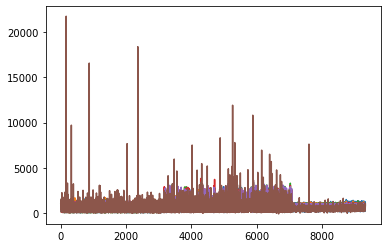

In [ ]:
plt.plot(test_preds_1)
plt.plot(test_preds_2)
plt.plot(test_preds_3)
plt.plot(test_preds_4)
plt.plot(test_preds_5)
plt.plot(test_preds_6)


In [ ]:
test_preds = []
for i in range (0,len(test_preds_1)):
    test_preds.append(test_preds_1[i])
    test_preds.append(test_preds_2[i])
    test_preds.append(test_preds_3[i])
    test_preds.append(test_preds_4[i])
    test_preds.append(test_preds_5[i])
    test_preds.append(test_preds_6[i])
len(test_preds)

56016

In [ ]:
ttt=0
for i in range(0,len(test_preds)):
    if test_preds[i] > 4000:
      test_preds[i] = min(test_preds[i],merged_test["PaymentsHistory_1"][int(i/6)])
      ttt = ttt+1
ttt

30

In [ ]:
ss["Target"] = test_preds
ss.head(20)

,ID,Target
0,ID_6L67PAA x m1,889.223069
1,ID_6L67PAA x m2,976.950242
2,ID_6L67PAA x m3,1068.271817
3,ID_6L67PAA x m4,1031.571500
4,ID_6L67PAA x m5,1085.816659
5,ID_6L67PAA x m6,907.882278
6,ID_VJ80SX2 x m1,1081.207852
7,ID_VJ80SX2 x m2,1130.823791
8,ID_VJ80SX2 x m3,1071.714334
9,ID_VJ80SX2 x m4,1073.387012


In [ ]:
#ss.to_csv('baseline_xsub.csv', index=False)

In [ ]:
y_true_7 = np.concatenate((y_true_1,y_true_2,y_true_3,y_true_4,y_true_5,y_true_6))
y_true_7 = np.reshape(y_true_7, (6,len(merged_train))).T
y_true_7

array([[ 880.,  930.,  495.,  715.,  220.,  385.],
       [ 660.,  935.,  935.,  825.,  770.,  935.],
       [ 700., 1350., 1550., 1400., 1450., 1200.],
       ...,
       [ 680.,  460.,  799., 1070.,  820.,  401.],
       [1300., 1055., 1200., 1200., 1080.,  800.],
       [ 970., 1080.,  960.,  840., 1000.,  370.]])

In [ ]:
y_true_7.shape

(28007, 6)

In [ ]:
y_true_7 = np.append(y_true_1,y_true_2,y_true_3,y_true_4,y_true_5,y_true_6)
y_true_7 = np.append(y_true_7,y_true_3)
y_true_7 = np.append(y_true_7,y_true_4)
y_true_7 = np.append(y_true_7,y_true_5)
y_true_7 = np.append(y_true_7,y_true_6)
y_true_7

array([880., 660., 700., ..., 401., 800., 370.])

In [ ]:
selected_features = [c for c in merged_train.columns[1:] if "Date" not in c]
xtrain_loan = merged_train[selected_features]
ytrain_loan = y_true_7
## Split
xtrain_loan, xval_loan, ytrain_loan, yval_loan = train_test_split(
    xtrain_loan, 
    ytrain_loan, 
    test_size=.3, 
    random_state=21, 
    shuffle=True
)
scaler = StandardScaler()
##Fit scaler
scaler.fit(X=xtrain_loan.values)

## Scale data
xtrain_loan = scaler.transform(X=xtrain_loan.values)
xval_loan = scaler.transform(X=xval_loan.values)

print(f"> Training inputs shape : {xtrain_loan.shape}, Training targets shape : {ytrain_loan.shape}")
print(f"> Validation inputs shape : {xval_loan.shape}, Training targets shape : {yval_loan.shape}")

> Training inputs shape : (19604, 35), Training targets shape : (19604, 6)
> Validation inputs shape : (8403, 35), Training targets shape : (8403, 6)


In [ ]:
train, max_len = pad_history(df=train, max_len=41)

xtrain = train.PaymentsHistory.values
ytrain = train[train.columns[-6:]].values

xs = np.array(xtrain.tolist()).reshape((xtrain.shape[0], 1, max_len))
ys = np.array(ytrain.tolist()).reshape((ytrain.shape[0], 1, 6))

train_ds = tf.data.Dataset.from_tensor_slices((xs, ys))

In [ ]:
merged2 = pd.concat([train, metadata], axis=1, join="inner")

In [ ]:
merged2 = pd.merge(left=train, right=pd.concat(objs=[metadata]).fillna(value=0.), on="ID")
merged2
xtrain = merged2.PaymentsHistory.values
deposits = merged2.Deposit.values
total_contract_value = merged2.TotalContractValue.values
for i in range (0,len(merged2)):
  xtrain[i].append(total_contract_value[i]-deposits[i]-np.sum(xtrain[i]))

In [ ]:
xs = np.array(xtrain.tolist()).reshape((xtrain.shape[0], 1, max_len+1))
ys = np.array(ytrain.tolist()).reshape((ytrain.shape[0], 1, 6))
train_ds = tf.data.Dataset.from_tensor_slices((xs, ys))

In [ ]:
xtrain[2][41] 

In [ ]:
i=0
np.sum(xtrain[i])

## Modelling

In [ ]:
def build_model():
    
    payments_inp = keras.Input(shape=(41), name="payments_inputs")
    status_inp = keras.Input(shape=(xtrain_loan.shape[1]), name="status_inputs")
    
    x1 = keras.layers.Dense(35, activation="sigmoid", name="x1")(status_inp)
    out1 = keras.layers.Dense(1, name="loan_status_out")(x1)
    
    
    x2 = keras.layers.Dense(20, activation="sigmoid", name="x2")(payments_inp)
    x2_out = keras.layers.Dense(30, activation="sigmoid", name="payment_out")(x2)
    
    concat = keras.layers.Concatenate(name="concat_layer")([out1, x2_out])
    out2 = keras.layers.Dense(6, name="out")(concat)
    
    # Model
    model = keras.Model(inputs=[payments_inp, status_inp], outputs=[out1, out2])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    wgt = {"out1":.7, "out2":.3}
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
        loss_weights=wgt
    )

    model.summary()
    
    return model


def build_simple_model():
    
    payments_inp = keras.Input(shape=(35), name="payments_inputs")

    x = keras.layers.Dense(30, activation="sigmoid", name="x2")(payments_inp)
    x2 = keras.layers.Dense(40, activation="sigmoid", name="x3")(x)
    x_out = keras.layers.Dense(30, activation="sigmoid", name="payment_out")(x2)
    
    out = keras.layers.Dense(6, name="out")(x_out)
    
    # Model
    model = keras.Model(inputs=[payments_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

    model.summary()
    
    return model


def build_status_model():
    
    status_inp = keras.Input(shape=(xtrain_loan.shape[1]), name="status_inputs")

    x = keras.layers.Dense(20, activation="sigmoid", name="x2")(status_inp)
    x_out = keras.layers.Dense(30, activation="sigmoid", name="statut_out")(x)
    
    out = keras.layers.Dense(6, name="out")(x)
    
    # Model
    model = keras.Model(inputs=[status_inp], outputs=[out])
    
    opt = keras.optimizers.Adam(learning_rate=0.01)
    
    model.compile(
        loss="mean_squared_error",
        optimizer=opt,
    )

    model.summary()
    
    return model

In [ ]:
model = build_simple_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
payments_inputs (InputLayer) [(None, 35)]              0         
_________________________________________________________________
x2 (Dense)                   (None, 30)                1080      
_________________________________________________________________
x3 (Dense)                   (None, 40)                1240      
_________________________________________________________________
payment_out (Dense)          (None, 30)                1230      
_________________________________________________________________
out (Dense)                  (None, 6)                 186       
Total params: 3,736
Trainable params: 3,736
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.compat.v1.disable_eager_execution()

# model
#inputs = tf.keras.layers.Input((6*24*7, 13))
inputs = tf.keras.layers.Input((35,1), name="payments_inputs")
#inputs = tf.keras.layers.BatchNormalization(inputs),
conv1 = tf.keras.layers.Conv1D(200, kernel_size=6, strides=1, activation='relu')(inputs)
#conv1 = tf.keras.layers.BatchNormalization()(conv1),
trim1 = tf.keras.layers.Cropping1D((5, 0))(conv1)
conv2 = tf.keras.layers.Conv1D(50, kernel_size=6, strides=1, activation='relu')(trim1)
trim2 = tf.keras.layers.Cropping1D((1, 0))(conv2)
conv3 = tf.keras.layers.Conv1D(30, kernel_size=6, strides=1, activation='relu')(trim2)
trim3 = tf.keras.layers.Cropping1D((5, 0))(conv3)
conv4 = tf.keras.layers.Conv1D(30, kernel_size=6, strides=1, activation='relu')(trim3)
conv5 = tf.keras.layers.Conv1D(30, kernel_size=4, strides=1, activation='relu')(conv4)
dense = tf.keras.layers.Dense(50, activation='relu')(conv5)
output = tf.keras.layers.Flatten()(tf.keras.layers.Dense(6)(dense))
model = tf.keras.Model(inputs, output)
# Model
#model = tf.keras.Model(inputs=[payments_inp], outputs=[out])
    
model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
payments_inputs (InputLayer) [(None, 35, 1)]           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 30, 200)           1400      
_________________________________________________________________
cropping1d_24 (Cropping1D)   (None, 25, 200)           0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 20, 50)            60050     
_________________________________________________________________
cropping1d_25 (Cropping1D)   (None, 19, 50)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 14, 30)            9030      
_________________________________________________________________
cropping1d_26 (Cropping1D)   (None, 9, 30)             0   

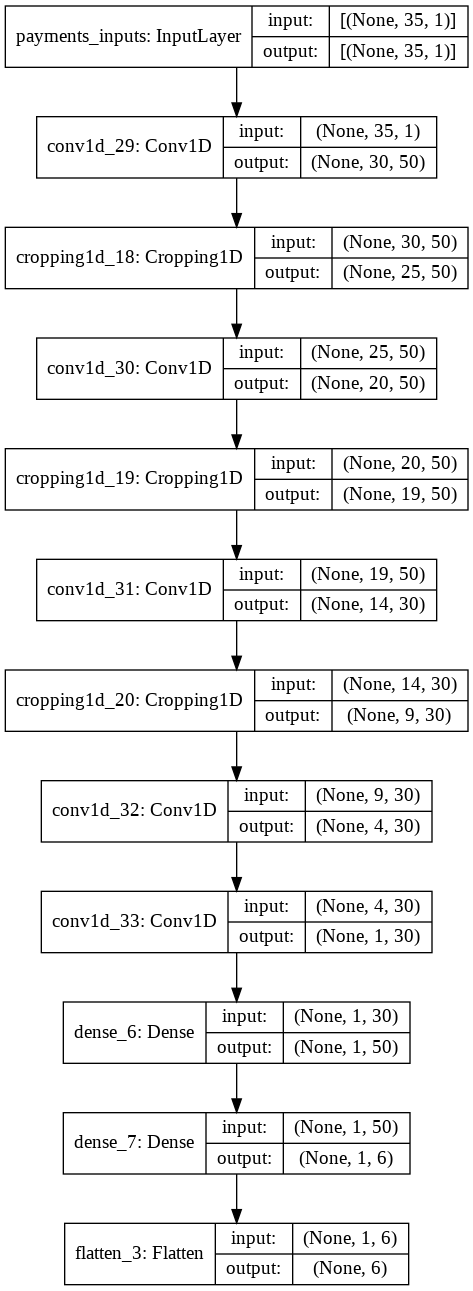

In [ ]:
tf.keras.utils.plot_model(
        model,
        to_file="../model.png", 
        show_shapes=True
    )

## Learning phase

In [ ]:
model.fit(xtrain_loan.reshape((xtrain_loan.shape[0], xtrain_loan.shape[1], 1)), ytrain_loan, batch_size = 8, epochs=250, validation_data=(xval_loan.reshape((xval_loan.shape[0], xval_loan.shape[1], 1)), yval_loan))

Train on 19604 samples, validate on 8403 samples
Epoch 1/250
19604/19604 [==============================] - 24s 1ms/sample - loss: 632325.3682 - root_mean_squared_error: 795.1893 - val_loss: 693140.3719 - val_root_mean_squared_error: 832.5505
Epoch 2/250
19604/19604 [==============================] - 24s 1ms/sample - loss: 592378.5339 - root_mean_squared_error: 769.6611 - val_loss: 699875.7062 - val_root_mean_squared_error: 836.5858
Epoch 3/250
19604/19604 [==============================] - 24s 1ms/sample - loss: 575749.8882 - root_mean_squared_error: 758.7820 - val_loss: 665053.4096 - val_root_mean_squared_error: 815.5083
Epoch 4/250
19604/19604 [==============================] - 25s 1ms/sample - loss: 569961.1553 - root_mean_squared_error: 754.9580 - val_loss: 659818.4023 - val_root_mean_squared_error: 812.2922
Epoch 5/250
19604/19604 [==============================] - 25s 1ms/sample - loss: 565175.9778 - root_mean_squared_error: 751.7820 - val_loss: 659990.0856 - val_root_mean_squar

In [ ]:
preds = model.predict(xval_loan.reshape((xval_loan.shape[0], xval_loan.shape[1], 1)))
preds

array([[ 894.921  ,  887.49274,  872.4846 ,  868.3082 ,  911.7198 ,
         837.1639 ],
       [1084.2162 , 1074.1227 , 1057.308  , 1049.6206 , 1101.907  ,
        1013.4644 ],
       [ 615.48004,  611.9861 ,  599.64484,  600.6515 ,  630.962  ,
         576.90564],
       ...,
       [ 335.1192 ,  335.57257,  325.90692,  332.11365,  349.27994,
         315.79077],
       [ 853.892  ,  847.0414 ,  832.42487,  829.00946,  870.49744,
         798.95135],
       [ 335.1192 ,  335.57257,  325.90692,  332.11365,  349.27994,
         315.79077]], dtype=float32)

In [ ]:
yval_loan

array([[ 935.,  825.,  935., 1705., 1320.,  110.],
       [1485., 1485., 1540., 1485., 1320.,  916.],
       [ 360.,  360.,  360.,  600.,  680., 1000.],
       ...,
       [  40.,  150.,   40.,  100.,   30.,   75.],
       [ 780., 1220., 1100., 1200., 1300.,  152.],
       [1220., 1100., 1380., 1200., 1040.,  360.]])

In [ ]:
xs = np.array(xtrain.tolist()).reshape((xtrain.shape[0], max_len+1,1))
ys = np.array(ytrain.tolist()).reshape((ytrain.shape[0],  6))
ys.shape

In [ ]:
#model.compile(optimizer, loss)
model.fit(xs[:len(xs)], ys[:len(ys)], batch_size=32, epochs=20)

In [ ]:
#model.fit(train_ds, batch_size=32, epochs=20)

## Eval/Inference time

In [ ]:
def predict(test:pd.DataFrame):
    test, max_len = pad_history(df=test, max_len=41)

    xtest = test.PaymentsHistory.values
    xtest = np.array(xtest.tolist()).reshape((xtest.shape[0], 1, max_len))

    merged_test2 = pd.merge(left=test, right=pd.concat(objs=[metadata]).fillna(value=0.), on="ID")
    xtest = merged_test2.PaymentsHistory.values
    
    deposits = merged_test2.Deposit.values
    total_contract_value = merged_test2.TotalContractValue.values

    w = []
    for i in range (0,len(merged_test2)):
        xtest[i].append(total_contract_value[i]-deposits[i]-np.sum(xtest[i]))
        w.append(xtest[i][-1])
        #print(111, w, xtest[i][-1])
    
    print(w)
    
    xts = np.array(xtest.tolist()).reshape((xtest.shape[0],  max_len+1, 1))
    print(xts)

    test_ds = tf.data.Dataset.from_tensor_slices(xts)
    preds = model.predict(xts)

    print(preds)
    
    assert preds.shape[0] == test.shape[0], f"Shape mismatch, {preds.shape[0]} predictions found while test set has {test.shape[0]} rows"
    
    return preds.flatten(),w

In [ ]:
merged_test2 = pd.merge(left=test, right=pd.concat(objs=[metadata]).fillna(value=0.), on="ID")
merged_test2
xtest = merged_test2.PaymentsHistory.values
deposits = merged_test2.Deposit.values
total_contract_value = merged_test2.TotalContractValue.values
i=0
#total_contract_value[i]-deposits[i]-np.sum(xtest[i])
xtest = xtest.reshape((xtest.shape[0])).tolist()
#np.sum(xtest)
type(xtest[0])

In [ ]:
preds,w = predict(test=test)

In [ ]:
w[:10]
t = 0
for k in range(0,int(len(preds)/6)):
  sum = 0
  for i in range(0,6):
    sum = sum+preds[t]
    t = t+1
  for i in range(0,6):
    preds[t-6+i] = min(max(100,(w[k]*preds[t-6+i])/sum),1200)

In [ ]:
preds = predict(test=test)

## Create submission

In [ ]:
ss["Target"] = preds

In [ ]:
ss.to_csv('baseline_sub.csv', index=False)